In [1]:
import sys
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('../src/')
from utils.nexdata import *

params = NexData(nexus_folder='../')
set_random_seeds(params.data_params['default_seed'])

2024-06-09 23:35:39,833 - utils.nexdata - INFO - Loading config file ../config/config.yaml
2024-06-09 23:35:39,835 - utils.nexdata - INFO - waves_palmas train path: ../data/raw/santos_dataset/train/waves_palmas.parquet
2024-06-09 23:35:39,836 - utils.nexdata - INFO - waves_palmas test path: ../data/raw/santos_dataset/test/waves_palmas.parquet
2024-06-09 23:35:39,837 - utils.nexdata - INFO - current_praticagem train path: ../data/raw/santos_dataset/train/current_praticagem.parquet
2024-06-09 23:35:39,838 - utils.nexdata - INFO - current_praticagem test path: ../data/raw/santos_dataset/test/current_praticagem.parquet
2024-06-09 23:35:39,892 - utils.nexdata - INFO - Random seed: 42
2024-06-09 23:35:39,893 - utils.nexdata - INFO - Default device: cuda
2024-06-09 23:35:39,894 - utils.nexdata - INFO - Defining paths...


In [2]:
target_features = params.features['current_praticagem']
id_experiment = 'chronos_forecast_composed'

df_train_target = pd.read_parquet(target_features['train_filepath'])
df_test_target = pd.read_parquet(target_features['test_filepath'])

df_train_processed_target = process_dataframe(
    df_train_target,
    target_features['train_start_date'],
    target_features['train_end_date'],
    params.data_params['target_freq'],
    params.data_params['interp_method'],
    params.data_params['datetime_col'],
    params.data_params['round_freq'])

df_test_processed_target = process_dataframe(
    df_test_target,
    target_features['test_start_date'],
    target_features['test_end_date'],
    params.data_params['target_freq'],
    params.data_params['interp_method'],
    params.data_params['datetime_col'],
    params.data_params['round_freq'])

In [3]:
context_len = params.model_params['context_window_len']
forecast_len = params.model_params['forecast_len']
shift = params.model_params['shift']
mode = params.model_params['windowing_mode']

X_test_index, y_test_index = generate_indices(df_test_processed_target,
                                                context_len,
                                                forecast_len,
                                                shift,
                                                mode)

100%|██████████| 179/179 [00:00<00:00, 7043.23it/s]


In [4]:
import torch
from chronos import ChronosPipeline
import numpy as np

chronos_pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-large',
    device_map='cuda',
    torch_dtype=torch.bfloat16,
    )

df_y_hat = pd.DataFrame()
df_y_hat.index = np.concatenate(y_test_index)
df_y_hat[params.data_params['datetime_col']] = df_test_processed_target.loc[
    df_y_hat.index,params.data_params['datetime_col']]

for target_feature in target_features['list_features']:
    print(f'Feature: {target_feature}')
    y_hat = []
    # add a data from train to improve de size of inference data
    train_signal = df_train_processed_target.loc[:,target_feature].values
    for idx in tqdm(range(len(X_test_index))):
        # get a signal from test. It's enough to perfom a zero-shot model
        test_signal = df_test_processed_target.loc[X_test_index[idx],
                                                    target_feature].values
        # concatenate train + test
        composed_signal = np.concatenate((train_signal, test_signal))
        # convert to tensor
        batch_context = torch.tensor(composed_signal)
        forecast = chronos_pipeline.predict(batch_context,forecast_len)
        predictions = np.quantile(forecast.numpy(), 0.5, axis=1)
        y_hat.extend(np.array(predictions[0]))
    df_y_hat[target_feature] = y_hat
filename = os.path.join(params.forecasted_dir,
    f'{target_features['name']}_{id_experiment}_{params.timestamp}.pkl')
df_y_hat.to_parquet(filename)
print(filename)

Feature: cross_shore_current


100%|██████████| 179/179 [09:24<00:00,  3.16s/it]

../data/forecasted/current_praticagem_chronos_forecast_composed_20240609_233539.pkl


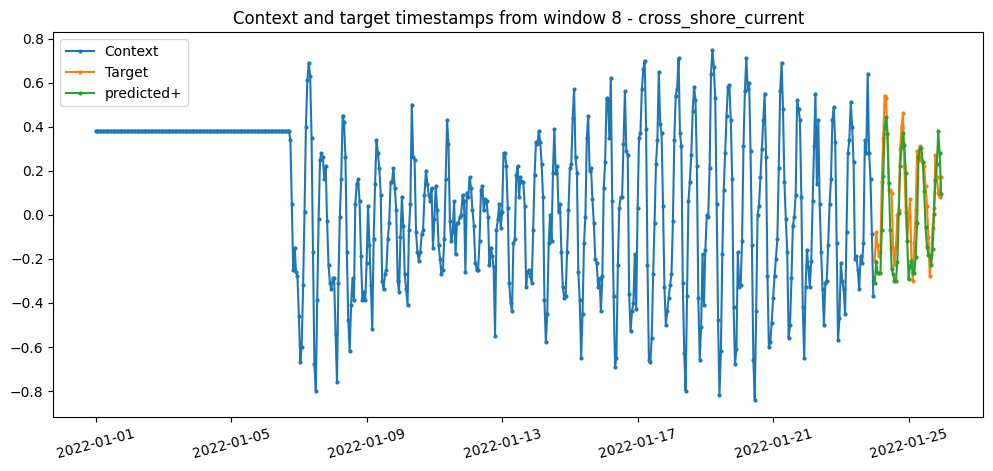

In [20]:
pvt = 8
feature = 'cross_shore_current'
plt.figure(figsize=(12, 5))
plt.title(f'Context and target timestamps from window {pvt} - {feature}')
plt.plot(df_test_processed_target.loc[X_test_index[pvt], 'datetime'],
            df_test_processed_target.loc[X_test_index[pvt], feature],
            label='Context', marker='o', markersize=2)

plt.plot(df_test_processed_target.loc[y_test_index[pvt], 'datetime'],
            df_test_processed_target.loc[y_test_index[pvt], feature],
            label='Target', marker='o', markersize=2)

plt.plot(df_test_processed_target.loc[y_test_index[pvt], 'datetime'],
            df_y_hat.loc[y_test_index[pvt],feature],
            label='predicted+', marker='o', markersize=2)

plt.xticks(rotation=15)
plt.legend()
plt.show()

In [ ]:
#########################################
#######             HS            #######
#########################################
from IPython.display import clear_output
import torch
from chronos import ChronosPipeline
from tqdm import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import sys

# Add the 'src/utils' directory to the module search path
sys.path.append('../src')
from utils.nexdata import *
from models.nexteacher import *

In [10]:
df_test_waves_palmas

,datetime,hs,tp,ws
0,2022-01-01 00:00:00+00:00,0.26,6.4,0.22
1,2022-01-01 00:20:00+00:00,0.24,10.0,0.23
2,2022-01-01 00:40:00+00:00,0.24,6.0,0.25
3,2022-01-01 01:00:00+00:00,0.25,12.9,0.36
4,2022-01-01 01:20:00+00:00,0.25,12.4,0.29
...,...,...,...,...
23065,2022-12-31 22:20:00+00:00,0.63,8.0,-0.05
23066,2022-12-31 22:40:00+00:00,0.59,8.5,-0.05
23067,2022-12-31 23:00:00+00:00,0.61,8.3,0.00
23068,2022-12-31 23:20:00+00:00,0.54,8.2,0.05


In [8]:
data_folder = '../data/raw/'
train_folder = f'{data_folder}santos_dataset/train/'
df_train_current_praticagem = pd.read_parquet(f'{train_folder}/current_praticagem.parquet')
df_train_astronomical_tide = pd.read_parquet(f'{train_folder}/astronomical_tide.parquet')
df_train_sofs_praticagem = pd.read_parquet(f'{train_folder}/sofs_praticagem.parquet')
df_train_ssh_praticagem = pd.read_parquet(f'{train_folder}/ssh_praticagem.parquet')
df_train_waves_palmas = pd.read_parquet(f'{train_folder}/waves_palmas.parquet')
df_train_wind_praticagem = pd.read_parquet(f'{train_folder}/wind_praticagem.parquet')

test_folder = f'{data_folder}santos_dataset/test/'
df_test_current_praticagem = pd.read_parquet(f'{test_folder}/current_praticagem.parquet')
df_test_astronomical_tide = pd.read_parquet(f'{test_folder}/astronomical_tide.parquet')
df_test_sofs_praticagem = pd.read_parquet(f'{test_folder}/sofs_praticagem.parquet')
df_test_ssh_praticagem = pd.read_parquet(f'{test_folder}/ssh_praticagem.parquet')
df_test_waves_palmas = pd.read_parquet(f'{test_folder}/waves_palmas.parquet')
df_test_wind_praticagem = pd.read_parquet(f'{test_folder}/wind_praticagem.parquet')

test_context_folder = f'{data_folder}santos_dataset/test/context_masks'
df_test_current_praticagem_context = pd.read_parquet(f'{test_context_folder}/current_praticagem_context.parquet')
df_test_astronomical_tide_context = pd.read_parquet(f'{test_context_folder}/astronomical_tide_context.parquet')
df_test_sofs_praticagem_context = pd.read_parquet(f'{test_context_folder}/sofs_praticagem_context.parquet')
df_test_ssh_praticagem_context = pd.read_parquet(f'{test_context_folder}/ssh_praticagem_context.parquet')
df_test_waves_palmas_context = pd.read_parquet(f'{test_context_folder}/waves_palmas_context.parquet')
df_test_wind_praticagem_context = pd.read_parquet(f'{test_context_folder}/wind_praticagem_context.parquet')

test_target_folder = f'{data_folder}santos_dataset/test/target_masks'
df_test_current_praticagem_target = pd.read_parquet(f'{test_target_folder}/current_praticagem_target.parquet')
df_test_waves_palmas_target = pd.read_parquet(f'{test_target_folder}/waves_palmas_target.parquet')

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

target_grid_feature = 'hs_ondas'
target_test_feature = 'hs'
folder_path = 'output/chronos/waves_palmas/hs/'

set_seed(42)

# Constants
freq_raw_feature = '10min'
tgt = 10
freq = '1h'
forecast_len = 48
# freq = '5min'
# forecast_len = 576

In [ ]:
train_df = df_train_sofs_praticagem
test_df = df_test_sofs_praticagem

In [ ]:
#train_df = df_train_sofs_praticagem
#test_df = df_test_sofs_praticagem

train_df = df_train_waves_palmas
test_df = df_test_waves_palmas

# Configurar parâmetros
start_date = '2020-01-01 00:00:00'
end_date = '2021-12-31 23:55:00'  # Intervalo completo de um dia
freq = '1h'  # Frequência de 1 hora
interp_method = 'linear'
datetime_col='datetime'
round_freq='5min'

# Chamar a função
df_processed = process_dataframe(train_df,
                                 start_date,
                                 end_date,
                                 freq,
                                 interp_method,
                                 datetime_col,
                                 round_freq)

# Imprimir os DataFrames para comparação
print("DataFrame Original:")
display(train_df)
print("\nDataFrame Processado:")
display(df_processed)

In [ ]:
import matplotlib.pyplot as plt

feature = 'tp'

plt.plot(df_processed.datetime,
         df_processed[feature],
         label=feature)
plt.legend()
plt.show()

In [ ]:
import pandas as pd

def create_shifted_date_dataframe(start_date, end_date,
                                  freq, context_len, shift,
                                  mode='sliding'):
    """
    Cria um DataFrame onde cada coluna contém um intervalo de 7 dias com a frequência especificada,
    deslocado pelo intervalo especificado em relação à coluna anterior.
    
    Parâmetros:
    - start_date: Data de início (str)
    - end_date: Data de fim (str)
    - freq: Frequência do intervalo (str, ex: '5min' para 5 minutos)
    - context_len: Duração de cada segmento (str, ex: '7days')
    - shift: Deslocamento entre as colunas (str, ex: '1day')
    
    Retorna:
    - DataFrame com colunas nomeadas sequencialmente de '001', '002', etc.
    """
    context_len = pd.Timedelta(context_len)
    shift = pd.Timedelta(shift)
    
    # Gerar o DateRange completo
    full_date_range = pd.date_range(start=start_date, end=end_date, freq=freq)
    
    # Lista para armazenar as colunas do DataFrame
    columns = []
    
    # Tamanho de cada segmento em termos de quantidade de elementos
    segment_size = int(context_len / pd.Timedelta(freq))
    
    # Número de colunas necessárias
    num_columns = int((pd.Timestamp(end_date) - pd.Timestamp(start_date)) / shift) + 1
    
    # Criação das colunas
    for i in range(num_columns):
        start_idx = i * int(shift / pd.Timedelta(freq))
        end_idx = start_idx + segment_size
        # Garantir que o segmento tem o tamanho correto
        if end_idx <= len(full_date_range):
            columns.append(full_date_range[start_idx:end_idx])
    
    # Criação do DataFrame com colunas nomeadas '001', '002', etc.
    df = pd.DataFrame({f'{i+1:03d}': col for i, col in enumerate(columns)})
    
    return df

def round_df(target_daterange, df_input,
             dt_column='datetime', freq='5min',
             fillna=False, interpolate=False):
    """
    Round the datetime column of a DataFrame to a specified
        frequency and adjust it to a target date range.

    Args:
        target_daterange (pd.DatetimeIndex): Target date range.
        df_input (pd.DataFrame): Input DataFrame.
        dt_column (str, optional): Name of the datetime column.
            Default is 'datetime'.
        freq (str, optional): Frequency to round the datetime
            column to. Default is '5min'.
        fillna (bool, optional): Whether to fill NaN values
            after merging. Default is False.
        interpolate (bool, optional): Whether to interpolate
            NaN values after merging. Default is False.

    Returns:
        pd.DataFrame: Adjusted DataFrame with rounded
            datetime column.
    """
    # Make a copy of the input DataFrame
    df_to_be_adjusted = df_input.copy()
    
    # Round the datetime column to the specified frequency and
    # remove timezone information
    df_to_be_adjusted[dt_column] = (
        df_to_be_adjusted[dt_column]
        .dt.round(freq)
        .dt.tz_localize(None)
    )

    # Create a DataFrame with the target date range
    df_aux = pd.DataFrame()
    df_aux[dt_column] = target_daterange

    # Merge the target date range DataFrame with the
    # adjusted DataFrame
    df_adjusted = df_aux.merge(
        df_to_be_adjusted,
        how='left',
        left_on=dt_column,
        right_on=dt_column
    )

    # Fill NaN values if specified
    if fillna:
        df_adjusted = df_adjusted.fillna(0)

    # Interpolate NaN values if specified
    if interpolate:
        df_adjusted = df_adjusted.interpolate(limit_direction='both')

    return df_adjusted

